## Import python libraries

In [30]:
%matplotlib inline

import h5py
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Any
import re

file = str
Dir = str
dat = str
Hz = int
SpikeUnits = List[np.ndarray]
Seconds = float
ms = float

## Drivers

Change me!

In [31]:
datafile = "/notebook/mea/data/160318 R2/E17_R2_DAD_50'_10s_5wait/E17_R2_DAD_50'_10s_5wait.result.hdf5"

## Useful functions

In [32]:
def read_spyking_results(filepath: str, sampling_rate: int) -> (
        SpikeUnits):
    """Read the results from Spyking Circus spike sorting."""

    result_regex = re.compile('.*\.result.hdf5$')
    if not re.match(result_regex, filepath):
        raise ValueError('Filepath must end in "result.hdf5"')

    result_h5 = h5py.File(filepath, 'r')

    spike_units = []
    for unit in result_h5["spiketimes"]:
        spikes = np.array(
            result_h5["spiketimes"][unit], dtype='int32') / sampling_rate
        spike_units.append(spikes)

    return spike_units

def last_spike_time(channels: SpikeUnits) -> (float):
    """Return time in seconds of last spike in channels array."""
    
    last_spike_time = 0
    for channel in channels:
        if channel is not None and channel.size != 0:
            last_spike_time = max(last_spike_time, np.amax(channel))

    if last_spike_time <= 0:
        raise ValueError("Last spike time cannot be zero/negative")

    return(last_spike_time)


def construct_on_off_stimulus(analog):
    """Take analog TTL and output indices for on/off.

    Assumes first TTL is an on and second TTL is an off. Divide
    by the sampling rate to convert to seconds."""

    ttl_index = np.argwhere(np.diff(stimulus)>20000)[:,0] + 1
    on = []
    off = []
    for i,v in np.ndenumerate(ttl_index):
        if i[0]%2 == 1:
            on.append(v)
        else:
            off.append(v)
    return on, off

def moving_window_gen(a, freq, win_size, win_step):
    """Generator that yields (time, data_vector) that form a moving window.

    Time is picked to be the center of the window. Data_vector guaranteed to be
    win_size in length. Thus up to win_step indices may be truncatedas there is
    insufficient data to pass a lenght of win_size."""

    start = 0
    end = start + win_size
    length = len(a)
    while end <= length:
        middle = (start + end) / 2
        yield (middle / freq, a[start:end])
        start += win_step
        end += win_step


def calc_variance(vector, freq: Hz=20000, win_size=100, win_step=100):
    """Return a vector of (time, variance) using a moving window.

    Time is the middle of the window. Variance is calculated over
    said window."""

    voltage_var = []
    time = []

    for i in moving_window(vector, freq, win_size, win_step):
        time.append(i[0])
        voltage_var.append(np.var(i[1]))

    return (time, voltage_var)


def spike_summary(spike_units: SpikeUnits) -> (str):
    """Print num_units, num_spikes and last spike time for SpikeUnits."""
    num_units = len(spike_units)
    num_spikes = np.sum([len(u) for u in spike_units])

    last_spike_time = 0
    for unit in spike_units:
        if unit.size != 0:
            last_spike_time = max(last_spike_time, np.max(unit))

    return "Number of units: {}\nNumber of spikes: {}\n" \
           "Last spike: {} seconds".format(
               num_units, num_spikes, last_spike_time)

def flatten(spike_units: SpikeUnits) -> (np.ndarray):
    """Turn list of arrays into a single array."""
    return np.hstack([c for c in spike_units if c is not None])

### Plotting

In [33]:
def spike_histogram(channels: SpikeUnits, bin_width: Seconds=0.1,
                    time: (Seconds, Seconds)=(None, None), plot=True) -> (Any):
    """
    Plot histogram of summed spike counts across all channels.

    Args:
        channels: List of numpy arrays; each float represents spike times.
        bin_width: Size of histogram bin width in seconds.
        time: Tuple of (start_time, end_time) i

    Returns:
        matplotlib pyplot figure (can call .show() to display).

    Raises:
        ValueError for bad bin_width.
    """

    if bin_width <= 0:
        raise ValueError("bin_width must be greater than zero")

    # flatten array
    all_spikes = np.hstack([c for c in channels if c is not None])

    # filter for desired range
    start_time = time[0]
    end_time = time[1]
    if start_time is not None:
        all_spikes = all_spikes[all_spikes > start_time]
    else:
        start_time = 0

    if end_time is not None:
        all_spikes = all_spikes[all_spikes < end_time]
    else:
        end_time = last_spike_time(channels)

    # add bin_width to last_time so histogram includes final edge
    bins = np.arange(start_time, np.ceil(end_time) + bin_width, bin_width)

    # plot histogram
    if plot is True:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.hist(all_spikes, bins)
    else:
        return(np.histogram(all_spikes, bins))


def isi_histogram(channels: SpikeUnits, bin_width: Seconds=1/1000,
                  time: (Seconds, Seconds)=(0, 100/1000), average=True,
                  fig_size=(10, 5)) -> (Any):
    channels = [np.diff(c) for c in channels]
    # Unit is seconds so x is in ms for x/1000
    bins = np.arange(time[0], time[1], bin_width)
    fig = plt.figure(figsize=fig_size)

    if average:
        # flatten array
        all_isi = np.hstack([c for c in channels if c is not None])

        ax = fig.add_subplot(111)
        ax.hist(all_isi, bins)
    else:
        subp = subplot_generator(channels,5)
        for channel in channels:
            ax = fig.add_subplot(*next(subp))
            ax.hist(channel, bins)


def visualize_spikes(spike_units: SpikeUnits, fig_size=(30, 15)):
    fig = plt.figure(figsize=fig_size)

    # Draw each spike as black line
    ax = fig.add_subplot(211)
    
    for i, unit in enumerate(spike_units):
        ax.vlines(spike_units[i], i, i + 1)

    # Plot histogram
    ax2 = fig.add_subplot(212)
    hist, bins = spike_histogram(spike_units, plot=False)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    ax2.bar(center, hist, align='center', width=width)


# Helpers


def subplot_generator(n_charts, num_cols):
    """Generate arguments for matplotlib add_subplot.

    Must use * to unpack the returned tuple. For example,

    >>> fig = plt.figure()
    <matplotlib.figure.Figure at 0x10fdec7b8>
    >>> subp = subplot_generator(4,2)
    >>> fig.add_subplot(*next(subp))
    <matplotlib.axes._subplots.AxesSubplot at 0x112cee6d8>

    """

    if type(n_charts) is list:
        n_charts = len(n_charts)

    num_rows = n_charts // num_cols + (n_charts % num_cols != 0)
    n = 1
    while n <= n_charts:
        yield (num_rows, num_cols, n)
        n += 1

## Setup

In [34]:
datafile

"/notebook/mea/data/160318 R2/E17_R2_DAD_50'_10s_5wait/E17_R2_DAD_50'_10s_5wait.result.hdf5"

In [35]:
spikes = read_spyking_results(datafile, 20000)

## Examples

In [36]:
print(spike_summary(spikes))

Number of units: 87
Number of spikes: 240059
Last spike: 114.9948 seconds


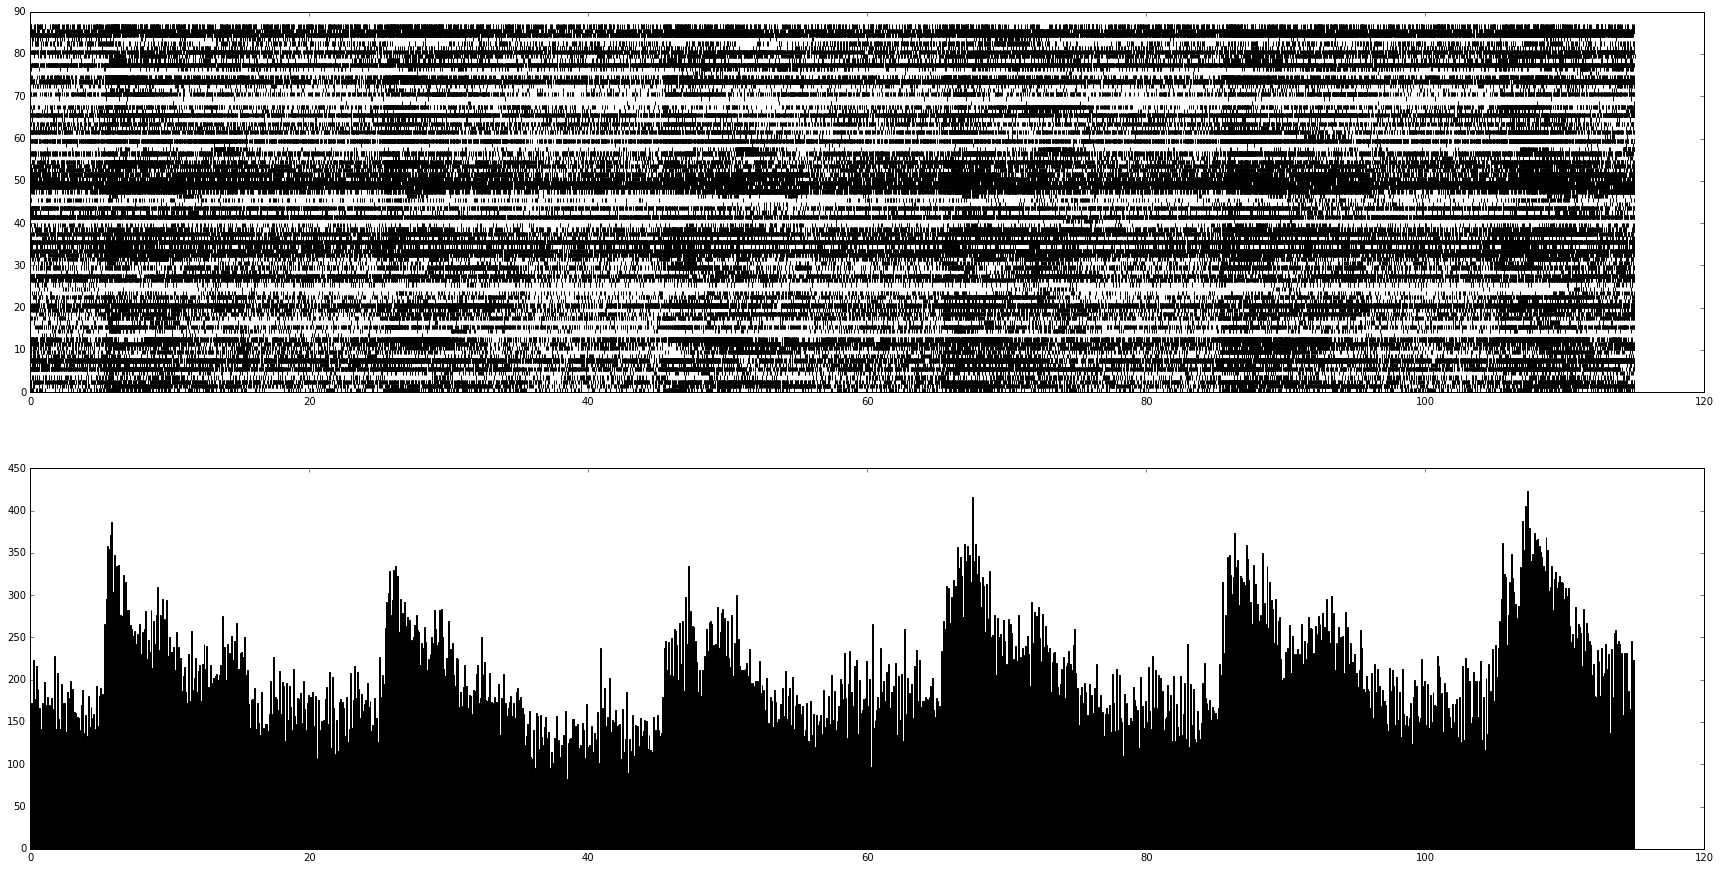

In [37]:
visualize_spikes(spikes)

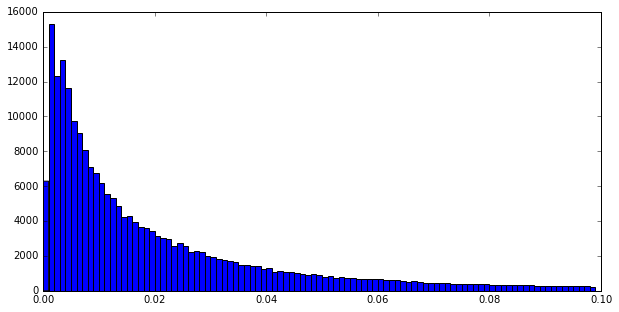

In [38]:
isi_histogram(spikes)

## Questions
1. Write a function that outputs the number of spikes of each channel
2. Construct a histogram for each of the 5 channels with the most spikes.
1. Write a function that predicts when the light turned on based on spike response
2. Using the output of function (1), construct a histogram of spike counts for 1 second following light on with 5ms bins (Hint: slice the data based on when the light turns on and one second after that and think about how to add each of these spiketrains...)